In [1]:
#Dependencies
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt


import utils.plotutils as plu
import utils.imreadin as imr

%matplotlib inline

In [12]:
#Model Parameters

#entwork params
compression = 5
patchsize = 16

#training params
batchsize = 100
iterations = 10000
epochs = 2

#noise
noisexsigma = 1e-3
noisersigma = 1e-3

minact = 0.1 #5e-1
minslo = 0.1 #1e-1
#bslfr = 1e-1

learning_rate = 0.01

In [13]:
#Load in images if we haven't yet.

def loadimages(psz):
    print("Loading Van Hateren Natural Image Database...")
    vhimgs = imr.vanHateren(
        img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
        #normalize=True,
        normalize_im = True,
        normalize_patch = False,
        patch_edge_size=psz
        )
    print("Done Loading!")    
    np.random.shuffle(vhimgs.images)
    print("Done Shuffling!")
    return(vhimgs, psz)

try:
    vhims
except NameError:
    vhims, loadedpatchsize = loadimages(patchsize)
    
if(patchsize != loadedpatchsize):
    vhims, loadedpatchsize = loadimages(patchsize)
       
print("Images Loaded.")

#params of images
imxlen = len(vhims.images[0,0,:])
imylen = len(vhims.images[0,:,0])
nimages = len(vhims.images[:,0,0])

nimstrained = batchsize * iterations

if(nimstrained > nimages):
    print('ERROR! Trying to train',nimstrained,'images, but we only have',nimages,'images!')
else:
    print('Training',nimstrained,'out of',nimages,'total image patches.')

Images Loaded.
Training 1000000 out of 4685824 total image patches.


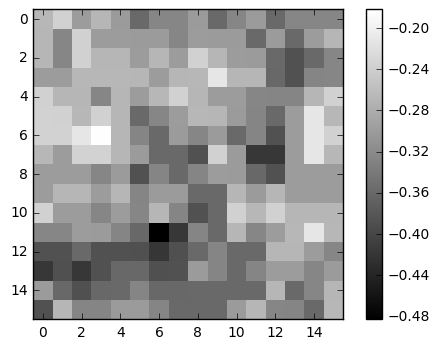

In [14]:
#show an example image
plt.imshow(vhims.images[100],cmap='gray',interpolation='none')
plt.colorbar()

In [15]:
nneurons = np.int(imxlen*imylen/compression)
print('Compressing by',compression,'for a total of',nneurons,'neurons')

#input image
x = tf.placeholder(tf.float32, shape=(batchsize, imxlen*imylen),name='input_image')
#output image
#xp = tf.placeholder(tf.float32, shape=(batchsize,imxlen*imylen),name='output_image')

#noise
nxc = noisexsigma**2
nrc = noisersigma**2
nx = tf.constant(nxc,dtype=tf.float32,name='input_noise')
nr = tf.constant(nrc,dtype=tf.float32,name='internal_noise')

#weights
win = tf.Variable(tf.random_normal([imxlen*imylen,nneurons],dtype=tf.float32,stddev=0.1),name='weights_in')
#wout = tf.Variable(tf.random_normal([nneurons,imxlen*imylen],dtype=tf.float32,stddev=0.01),name='weights_out')
#wout = tf.placeholder(tf.float32, shape=np.shape(win),name='weights_out')
#bias
bias = tf.Variable(tf.random_normal([nneurons],dtype=tf.float32,stddev=0.1),name='bias')

#calculate inner layer
y = tf.nn.sigmoid(tf.add(tf.matmul(tf.add(x,nx),win),bias))
#y = tf.nn.tanh(tf.add(tf.matmul(tf.add(x,nx),win),bias))

#calculate ouer layer
wout = tf.transpose(win)
xp = tf.matmul(y,wout)
#calculate cost
cost = tf.sqrt(tf.reduce_mean(tf.square(x-xp)))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Compressing by 5 for a total of 51 neurons


In [ ]:
#run it!
#sess = tf.Session
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #save evolution of system over training
    cost_evolution = []
    y_evolution = []
    
    images = []
    recons = []
    
    #train over niterations
    nits = iterations #full run
    
    print('Training {} iterations in {} epochs...'.format(nits, epochs))
    for epoch in range(epochs):
        print('\nEpoch {}: '.format(epoch+1))
        np.random.shuffle(vhims.images)
        for ii in range(nits):
            image = np.reshape(vhims.images[ii*batchsize:(1+ii)*batchsize,:,:],(batchsize,imxlen*imylen)).astype(np.float32)
            #noise_input = np.random.normal(0,noisexsigma,[patchsize**2,batchsize]).astype(np.float32)*0.
            #noise_response = np.random.normal(0,noisersigma,[nneurons,batchsize]).astype(np.float32)*0.
            sess.run(train_step, feed_dict={x:image})

            #save evolution of params
            objcost, yr = sess.run([cost,y], feed_dict={x:image})
            cost_evolution.append(objcost)
            y_evolution.append(np.mean(yr))
            
            if(ii%(int((nits)/10))==0):
                print(str(ii)+', ',end="")
                #and save our image and reconstruction
                images.append(np.reshape(image,[batchsize,imxlen,imylen]))
                recons.append(np.reshape(sess.run(xp, feed_dict={x:image}),[batchsize,imxlen,imylen]))
    
    
    weights = sess.run(win, feed_dict={x:image})
    print('\nDone!')

Training 10000 iterations in 2 epochs...

Epoch 1: 
0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 
Epoch 2: 
0, 1000, 2000, 3000, 4000, 

In [ ]:
#Show our weights
wr = np.rollaxis(np.reshape(weights,(imxlen,imylen,nneurons)),2)
plu.display_data_tiled(wr, normalize=False, title="weights", prev_fig=None)

In [ ]:
plt.figure(figsize=(6,6))

plt.subplot(2,1,1,title='Weights')
plt.plot(y_evolution)

plt.subplot(2,1,2,title='Objective')
plt.plot(cost_evolution)

plt.tight_layout()

In [ ]:
#show an example image and reconstruction from the last iteration of learning
patchnum = 6

#one example
plt.subplot(2,2,1,title='Patch')
plt.imshow(images[-1][patchnum],cmap='gray',interpolation='none')
plt.subplot(2,2,2,title='Reconstruction')
plt.imshow(recons[-1][patchnum],cmap='gray',interpolation='none')

#another
plt.subplot(2,2,3)
plt.imshow(images[-1][patchnum+1],cmap='gray',interpolation='none')
plt.subplot(2,2,4)
plt.imshow(recons[-1][patchnum+1],cmap='gray',interpolation='none')

plt.tight_layout()

bonus code - for now opencv isn't working

In [10]:
def plotonoff(allws):
    allws = weights
    #get on center
    onws = np.mean(allws,axis=0)>0
    onws = allws[:,onws]
    #get off center
    offws = np.mean(allws,axis=0)<0
    offws = allws[:,offws]
    #keep track of the circles
    oncircs = []
    oncircs = []
    
    #blank 16x16 to draw circles
    onrfs = np.zeros_like(weights[0])
    offrfs = np.zeros_like(weights[0])
    
    #on cells
    
    for on in onws:
        circs = cv2.HoughCircles(on,cv2.CV_HOUGH_GRADIENT)
        #circs = cv2.HoughCircles(on, oncircs, cv2.CV_HOUGH_GRADIENT,
                           #dp=1.5, minDist=30, minRadius=3, maxRadius=10)
        cv2.circle(onrfs,((circ[0,0],i[0,1]),i[0,2],(0,255,0),2))
        
    #off cells
    for off in offws:
        circs = cv2.HoughCircles(off, offcircs, cv2.CV_HOUGH_GRADIENT,
                           dp=1.5, minDist=30, minRadius=3, maxRadius=10)
        cv2.circle(offrfs,((circ[0,0],i[0,1]),i[0,2],(0,255,0),2))
  
    
    #plot
    plt.figure(figsize=(6,6))

    plt.subplot(1,2,1,title='On')
    plt.imshow(onrfs)

    plt.subplot(1,2,2,title='Off')
    plt.imshow(offrfs)

    plt.tight_layout()
    

In [11]:
plotonoff(weights)

NameError: name 'cv2' is not defined